<a href="https://colab.research.google.com/github/PratyaoySarkar/Fake_Currency_Detection/blob/main/ResNet50_Adam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, accuracy_score
import numpy as np
import matplotlib.pyplot as plt

In [2]:
height = 300
width = 300

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(height, width, 3))

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [7]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
train_dir = "/content/drive/MyDrive/dataset/training"
validation_dir = "/content/drive/MyDrive/dataset/validation"

batch_size = 8

In [11]:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
 rotation_range=90,
 horizontal_flip=True,
 vertical_flip=True)

train_generator = train_datagen.flow_from_directory(train_dir,
 target_size=(height, width),
 batch_size=batch_size)

validation_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
 rotation_range=90,
 horizontal_flip=True,
 vertical_flip=True)

validation_generator = validation_datagen.flow_from_directory(validation_dir,
 target_size=(height, width),
 batch_size=batch_size,
 class_mode='categorical',
 shuffle=False)

Found 2813 images belonging to 2 classes.
Found 592 images belonging to 2 classes.


In [12]:
def build_finetune_model(base_model, dropout, fc_layers, num_classes):
    for layer in base_model.layers:
        layer.trainable = False
    x = base_model.output
    x = Flatten()(x)
    for fc in fc_layers:
        x = Dense(fc, activation='relu')(x)
        x = Dropout(dropout)(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    finetune_model = Model(inputs=base_model.input, outputs=predictions)

    return finetune_model

class_list = ['Real','Fake'] #the labels of our data
FC_Layers = [1024, 1024]
dropout = 0.5

finetune_model = build_finetune_model(base_model, dropout=dropout, fc_layers=FC_Layers, num_classes=len(class_list))

In [13]:
num_epochs = 20
num_train_images = train_generator.samples
num_validation_images = validation_generator.samples

In [14]:
#Define callbacks
checkpoint = ModelCheckpoint("ResNet50_Adam.h5", monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')

#Early stopping to prevent overfitting
early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=10, verbose=1, mode='auto')

#ReduceLROnPlateau to adjust learning rate when a metric has stopped improving
lr_scheduler = ReduceLROnPlateau(monitor='val_accuracy',
                factor=0.2,
                patience=5,
                verbose=1,
                min_lr=1e-6) # Lower bound on the learning rate.

# Compile the model with Adam optimizer
optimizer = Adam(learning_rate=0.001)
finetune_model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=['accuracy'])

# Train the model
history = finetune_model.fit(
    train_generator,
    steps_per_epoch=num_train_images // batch_size,
    epochs=num_epochs,
    validation_data=validation_generator,
    validation_steps=num_validation_images // batch_size,
    callbacks=[checkpoint, early, lr_scheduler]
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6714 - loss: 65.2256
Epoch 1: val_accuracy improved from -inf to 0.78547, saving model to ResNet50_Adam.h5


351/351 ━━━━━━━━━━━━━━━━━━━━ 919s 3s/step - accuracy: 0.6716 - loss: 65.1481 - val_accuracy: 0.7855 - val_loss: 6.4214 - learning_rate: 0.0010
Epoch 2/20
  1/351 ━━━━━━━━━━━━━━━━━━━━ 36s 103ms/step - accuracy: 0.6250 - loss: 10.5318

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_accuracy did not improve from 0.78547
351/351 ━━━━━━━━━━━━━━━━━━━━ 17s 48ms/step - accuracy: 0.6250 - loss: 10.5318 - val_accuracy: 0.7753 - val_loss: 7.3716 - learning_rate: 0.0010
Epoch 3/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.8071 - loss: 6.0769
Epoch 3: val_accuracy improved from 0.78547 to 0.83615, saving model to ResNet50_Adam.h5


351/351 ━━━━━━━━━━━━━━━━━━━━ 184s 374ms/step - accuracy: 0.8071 - loss: 6.0733 - val_accuracy: 0.8361 - val_loss: 1.7866 - learning_rate: 0.0010
Epoch 4/20
  1/351 ━━━━━━━━━━━━━━━━━━━━ 36s 103ms/step - accuracy: 0.8750 - loss: 0.2315
Epoch 4: val_accuracy improved from 0.83615 to 0.85642, saving model to ResNet50_Adam.h5


351/351 ━━━━━━━━━━━━━━━━━━━━ 45s 127ms/step - accuracy: 0.8750 - loss: 0.2315 - val_accuracy: 0.8564 - val_loss: 1.5478 - learning_rate: 0.0010
Epoch 5/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - accuracy: 0.8177 - loss: 1.5563
Epoch 5: val_accuracy improved from 0.85642 to 0.85811, saving model to ResNet50_Adam.h5


351/351 ━━━━━━━━━━━━━━━━━━━━ 127s 361ms/step - accuracy: 0.8177 - loss: 1.5552 - val_accuracy: 0.8581 - val_loss: 0.8338 - learning_rate: 0.0010
Epoch 6/20
  1/351 ━━━━━━━━━━━━━━━━━━━━ 35s 102ms/step - accuracy: 0.7500 - loss: 0.5302
Epoch 6: val_accuracy did not improve from 0.85811
351/351 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.7500 - loss: 0.5302 - val_accuracy: 0.8581 - val_loss: 0.7144 - learning_rate: 0.0010
Epoch 7/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - accuracy: 0.8358 - loss: 0.6324
Epoch 7: val_accuracy did not improve from 0.85811
351/351 ━━━━━━━━━━━━━━━━━━━━ 153s 266ms/step - accuracy: 0.8358 - loss: 0.6327 - val_accuracy: 0.8209 - val_loss: 1.3055 - learning_rate: 0.0010
Epoch 8/20
  1/351 ━━━━━━━━━━━━━━━━━━━━ 33s 96ms/step - accuracy: 0.6250 - loss: 0.4612
Epoch 8: val_accuracy did not improve from 0.85811
351/351 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.6250 - loss: 0.4612 - val_accuracy: 0.8142 - val_loss: 1.3233 - learning_rate: 0.0010
Epoch 

351/351 ━━━━━━━━━━━━━━━━━━━━ 119s 339ms/step - accuracy: 0.7454 - loss: 0.6279 - val_accuracy: 0.8598 - val_loss: 0.5433 - learning_rate: 2.0000e-04
Epoch 12/20
  1/351 ━━━━━━━━━━━━━━━━━━━━ 35s 102ms/step - accuracy: 0.8750 - loss: 0.4825
Epoch 12: val_accuracy did not improve from 0.85980
351/351 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - accuracy: 0.8750 - loss: 0.4825 - val_accuracy: 0.8530 - val_loss: 0.7366 - learning_rate: 2.0000e-04
Epoch 13/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - accuracy: 0.7737 - loss: 0.4509
Epoch 13: val_accuracy did not improve from 0.85980
351/351 ━━━━━━━━━━━━━━━━━━━━ 100s 266ms/step - accuracy: 0.7737 - loss: 0.4510 - val_accuracy: 0.8547 - val_loss: 0.4605 - learning_rate: 2.0000e-04
Epoch 14/20
  1/351 ━━━━━━━━━━━━━━━━━━━━ 35s 101ms/step - accuracy: 0.7500 - loss: 0.5566
Epoch 14: val_accuracy did not improve from 0.85980
351/351 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.7500 - loss: 0.5566 - val_accuracy: 0.8480 - val_loss: 0.4354 - learning_

351/351 ━━━━━━━━━━━━━━━━━━━━ 121s 346ms/step - accuracy: 0.7976 - loss: 0.3873 - val_accuracy: 0.8615 - val_loss: 0.5429 - learning_rate: 2.0000e-04
Epoch 16/20
  1/351 ━━━━━━━━━━━━━━━━━━━━ 36s 103ms/step - accuracy: 0.6250 - loss: 0.4406
Epoch 16: val_accuracy improved from 0.86149 to 0.86824, saving model to ResNet50_Adam.h5


351/351 ━━━━━━━━━━━━━━━━━━━━ 44s 125ms/step - accuracy: 0.6250 - loss: 0.4406 - val_accuracy: 0.8682 - val_loss: 0.5406 - learning_rate: 2.0000e-04
Epoch 17/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - accuracy: 0.8049 - loss: 0.4169
Epoch 17: val_accuracy improved from 0.86824 to 0.87500, saving model to ResNet50_Adam.h5


351/351 ━━━━━━━━━━━━━━━━━━━━ 123s 348ms/step - accuracy: 0.8049 - loss: 0.4169 - val_accuracy: 0.8750 - val_loss: 0.5478 - learning_rate: 2.0000e-04
Epoch 18/20
  1/351 ━━━━━━━━━━━━━━━━━━━━ 35s 102ms/step - accuracy: 0.7500 - loss: 0.3504
Epoch 18: val_accuracy improved from 0.87500 to 0.88345, saving model to ResNet50_Adam.h5


351/351 ━━━━━━━━━━━━━━━━━━━━ 45s 129ms/step - accuracy: 0.7500 - loss: 0.3504 - val_accuracy: 0.8834 - val_loss: 0.5985 - learning_rate: 2.0000e-04
Epoch 19/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - accuracy: 0.8114 - loss: 0.3806
Epoch 19: val_accuracy did not improve from 0.88345
351/351 ━━━━━━━━━━━━━━━━━━━━ 93s 266ms/step - accuracy: 0.8114 - loss: 0.3807 - val_accuracy: 0.8818 - val_loss: 0.5341 - learning_rate: 2.0000e-04
Epoch 20/20
  1/351 ━━━━━━━━━━━━━━━━━━━━ 35s 102ms/step - accuracy: 0.8750 - loss: 0.3564
Epoch 20: val_accuracy improved from 0.88345 to 0.89527, saving model to ResNet50_Adam.h5


351/351 ━━━━━━━━━━━━━━━━━━━━ 49s 139ms/step - accuracy: 0.8750 - loss: 0.3564 - val_accuracy: 0.8953 - val_loss: 0.3996 - learning_rate: 2.0000e-04


In [15]:
model = load_model("ResNet50_Adam.h5")
true_labels = validation_generator.classes
class_labels = list(validation_generator.class_indices.keys())
num_validation_samples = len(validation_generator.filenames)
steps = int(np.ceil(num_validation_samples / batch_size))
predictions = model.predict(validation_generator, steps=steps, verbose=1)
predicted_labels = np.argmax(predictions, axis=1)
print("--- Final Model Evaluation Report ---")
accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=class_labels))

74/74 ━━━━━━━━━━━━━━━━━━━━ 21s 234ms/step
--- Final Model Evaluation Report ---
Accuracy: 0.8834
Classification Report:
              precision    recall  f1-score   support

        fake       0.89      0.87      0.88       296
        real       0.87      0.90      0.88       296

    accuracy                           0.88       592
   macro avg       0.88      0.88      0.88       592
weighted avg       0.88      0.88      0.88       592



In [16]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Printing the final accuracy values
print(f"Final Training Accuracy: {train_acc[-1]:.4f}")
print(f"Final Validation Accuracy: {val_acc[-1]:.4f}")

Final Training Accuracy: 0.8750
Final Validation Accuracy: 0.8953


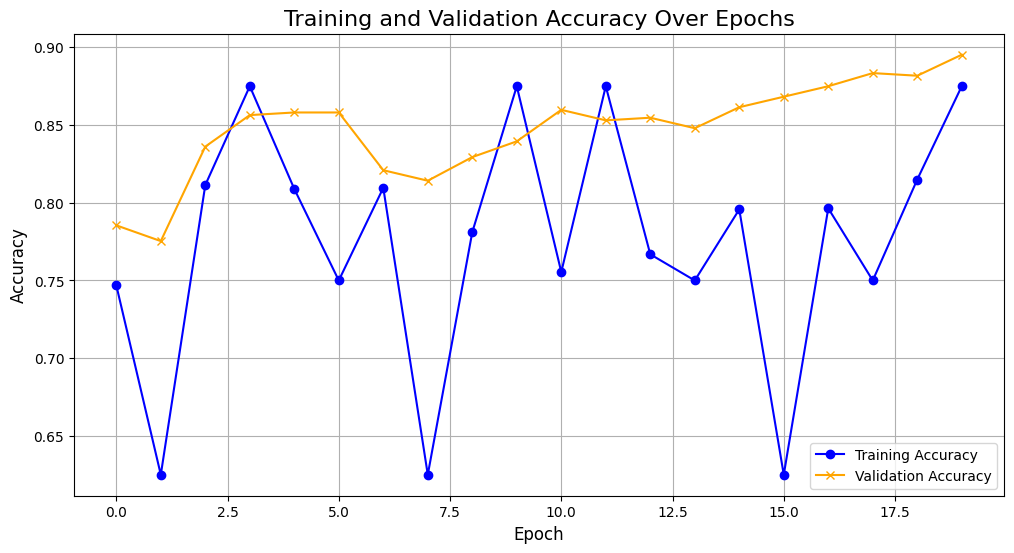

In [17]:
plt.figure(figsize=(12, 6))
plt.plot(train_acc, label='Training Accuracy', color='blue', marker='o')
plt.plot(val_acc, label='Validation Accuracy', color='orange', marker='x')

# Adding titles and labels for clarity
plt.title('Training and Validation Accuracy Over Epochs', fontsize=16)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(loc='best')
plt.grid(True)

# Display the plot
plt.show()